<!-- FIDE & Google Efficient Chess AI Challenge-->

<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: left; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
    FIDE & Google Efficient Chess AI Challenge<br>
</div>

In this notebook, I attempted to combine C and Python code to create an agent, as the Minimax function implementation in Python is not fast enough to perform well on the leaderboard.

I used the Kaggle kernel to compile the C code.

This is a first draft to demonstrate how one can integrate C functions into the agent. However, it is not fully functional yet. The C-based agent frequently causes errors during simulations, but I have not yet identified the exact cause. Based on replay observations, it seems the issue occurs during move validation checks, likely because the logic for those checks is missing.

To address this, I’ve added logic in the Python code as a fallback. If the C engine returns an illegal move, the Python code defaults to selecting a random move. Additionally, the C engine is bypassed altogether when time is running low.

This approach works within the Kaggle notebook but produces an error upon submission. I suspect this might be due to memory or CPU usage constraints, or possibly compilation issues. However, I am not entirely certain. If anyone has insights, please share them in the comment section.

In [1]:
# first let's make sure you have internet enabled
import requests
requests.get('http://www.google.com',timeout=10).ok

True

In [2]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [3]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import


In [4]:
%%writefile initial_agent.py
from Chessnut import Game
import random

def heuristic_chess_bot(obs):
    """
    A heuristic-based chess bot that prioritizes:
    - Checkmates
    - Captures
    - Promotions
    - Random moves
    Args:
        obs: Object with 'board' representing board state as FEN string
    Returns:
        Move in UCI notation
    """
    game = Game(obs.board)
    moves = list(game.get_moves())
    random.shuffle(moves)  # Randomize moves to add variation

    # Prioritize checkmates
    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    # Check for captures
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move

    # Check for promotions
    for move in moves:
        if "q" in move.lower():  # Queen promotion
            return move

    # Default to random move
    return random.choice(moves)


Writing initial_agent.py



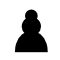
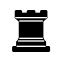
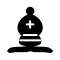
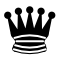
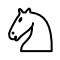
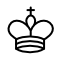
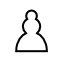
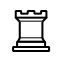
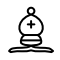
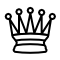
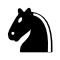
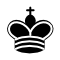

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

In [6]:
%%writefile chess_agent.c

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <stdint.h>
#include <math.h>

#define MAX_MOVES 256
#define INFINITY 1000000
#define MAX_DEPTH 5

// Piece values for evaluation (material)
const int PIECE_VALUES[7] = {
    0,    // EMPTY
    100,  // PAWN
    320,  // KNIGHT
    330,  // BISHOP
    500,  // ROOK
    900,  // QUEEN
    20000 // KING
};

// Piece-square tables (same as original)
static const int PAWN_TABLE[64] = {
     0,   0,   0,   0,   0,   0,   0,   0,
    50,  50,  50,  50,  50,  50,  50,  50,
    10,  10,  20,  30,  30,  20,  10,  10,
     5,   5,  10,  25,  25,  10,   5,   5,
     0,   0,   0,  20,  20,   0,   0,   0,
     5,  -5, -10,   0,   0, -10,  -5,   5,
     5,  10,  10, -20, -20,  10,  10,   5,
     0,   0,   0,   0,   0,   0,   0,   0
};

static const int KNIGHT_TABLE[64] = {
    -50,-40,-30,-30,-30,-30,-40,-50,
    -40,-20,  0,  0,  0,  0,-20,-40,
    -30,  0, 10, 15, 15, 10,  0,-30,
    -30,  5, 15, 20, 20, 15,  5,-30,
    -30,  0, 15, 20, 20, 15,  0,-30,
    -30,  5, 10, 15, 15, 10,  5,-30,
    -40,-20,  0,  5,  5,  0,-20,-40,
    -50,-40,-30,-30,-30,-30,-40,-50,
};

static const int BISHOP_TABLE[64] = {
    -20,-10,-10,-10,-10,-10,-10,-20,
    -10,  5,  0,  0,  0,  0,  5,-10,
    -10, 10, 10, 10, 10, 10, 10,-10,
    -10,  0, 10, 10, 10, 10,  0,-10,
    -10,  5, 10, 10, 10, 10,  5,-10,
    -10,  0, 10, 10, 10, 10,  0,-10,
    -10,  5,  0,  0,  0,  0,  5,-10,
    -20,-10,-10,-10,-10,-10,-10,-20,
};

static const int ROOK_TABLE[64] = {
     0,   0,   0,   0,   0,   0,  0,   0,
     5,  10,  10,  10,  10,  10, 10,   5,
    -5,   0,   0,   0,   0,   0,  0,  -5,
    -5,   0,   0,   0,   0,   0,  0,  -5,
    -5,   0,   0,   0,   0,   0,  0,  -5,
    -5,   0,   0,   0,   0,   0,  0,  -5,
    -5,   0,   0,   0,   0,   0,  0,  -5,
     0,   0,   0,   5,   5,   0,  0,   0
};

static const int QUEEN_TABLE[64] = {
    -20,-10,-10, -5, -5,-10,-10,-20,
    -10,  0,  5,  0,  0,  0,  0,-10,
    -10,  5,  5,  5,  5,  5,  0,-10,
     -5,  0,  5,  5,  5,  5,  0, -5,
     -5,  0,  5,  5,  5,  5,  0, -5,
    -10,  0,  5,  5,  5,  5,  0,-10,
    -10,  0,  0,  0,  0,  0,  0,-10,
    -20,-10,-10, -5, -5,-10,-10,-20
};

static const int KING_TABLE[64] = {
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -20,-30,-30,-40,-40,-30,-30,-20,
    -10,-20,-20,-20,-20,-20,-20,-10,
     20, 20,   0,   0,   0,   0, 20, 20,
     20, 30,  10,   0,   0,  10, 30, 20
};

enum Piece {
    EMPTY = 0,
    W_PAWN = 1, W_KNIGHT, W_BISHOP, W_ROOK, W_QUEEN, W_KING,
    B_PAWN = 7, B_KNIGHT, B_BISHOP, B_ROOK, B_QUEEN, B_KING
};

typedef struct {
    int squares[64];   
    int to_move;       
    int castling_rights; 
    int en_passant;     
    int halfmove_clock;
    int fullmove_number;
} Board;

typedef struct {
    int from;
    int to;
    int piece;
    int captured;
    int promotion;
    int is_castling;
    int is_en_passant;
    int prev_en_passant;
    int prev_castling_rights;
    int prev_halfmove_clock;
} Move;

int generate_moves(Board *board, Move *moves);
void apply_move(Board *board, Move *move);
void undo_move(Board *board, Move *move);
int evaluate_board(Board *board);
int quiesce(Board *board, int alpha, int beta, clock_t end_time);
int minimax(Board *board, int depth, int alpha, int beta, int maximizingPlayer, clock_t end_time);
int move_heuristic(Board *board, Move *move);
void sort_moves(Board *board, Move *moves, int num_moves);
const char *choose_best_move(Board *board, double per_move_time, double total_time);

static inline int piece_color(int piece) {
    if (piece >= W_PAWN && piece <= W_KING) return 1;
    if (piece >= B_PAWN && piece <= B_KING) return -1;
    return 0;
}

static inline int piece_type(int piece) {
    if (piece == EMPTY) return 0;
    int t = piece;
    if (t > 6) t -= 6; // Black pieces map to same type numbers as white
    return t; 
}

// Directions for knights and kings
static const int knight_offsets[8] = {-17,-15,-10,-6,6,10,15,17};
static const int king_offsets[8] = {-9,-8,-7,-1,1,7,8,9};

// Directions for sliding pieces
static const int bishop_offsets[4] = {-9,-7,7,9};
static const int rook_offsets[4] = {-8,-1,1,8};
static const int queen_offsets[8] = {-9,-8,-7,-1,1,7,8,9};

static inline int on_board(int sq) {
    return (sq >=0 && sq<64);
}

static inline int same_rank(int sq1,int sq2) {
    return (sq1/8 == sq2/8);
}

// Pseudo-legal move generation
int generate_moves(Board *board, Move *moves) {
    int num_moves = 0;
    int side = board->to_move; 
    int opp = -side;

    // Pawn move direction
    int pawn_dir = (side == 1) ? -8 : 8; 
    int start_rank_pawn = (side == 1) ? 6 : 1; // White pawns start at rank 6 (0-based from top), black at rank 1
    int promotion_rank = (side == 1) ? 0 : 7;  // Promotion rank for white: 0, black:7

    for (int i = 0; i < 64; i++) {
        int piece = board->squares[i];
        if (piece == EMPTY) continue;
        int c = piece_color(piece);
        if (c != side) continue;

        if (piece == W_PAWN || piece == B_PAWN) {
            // Forward moves
            int forward = i + pawn_dir;
            if (on_board(forward) && board->squares[forward] == EMPTY) {
                // Promotion?
                int from_rank = i/8;
                int to_rank = forward/8;
                if (to_rank == promotion_rank) {
                    // Promote to Q, R, B, N
                    int promos[4] = { (side==1?W_QUEEN:B_QUEEN),(side==1?W_ROOK:B_ROOK),(side==1?W_BISHOP:B_BISHOP),(side==1?W_KNIGHT:B_KNIGHT) };
                    for (int p=0;p<4;p++) {
                        moves[num_moves].from = i;
                        moves[num_moves].to = forward;
                        moves[num_moves].piece = piece;
                        moves[num_moves].captured = EMPTY;
                        moves[num_moves].promotion = promos[p];
                        moves[num_moves].is_castling = 0;
                        moves[num_moves].is_en_passant = 0;
                        moves[num_moves].prev_en_passant = -1;
                        num_moves++;
                    }
                } else {
                    moves[num_moves].from = i;
                    moves[num_moves].to = forward;
                    moves[num_moves].piece = piece;
                    moves[num_moves].captured = EMPTY;
                    moves[num_moves].promotion = EMPTY;
                    moves[num_moves].is_castling = 0;
                    moves[num_moves].is_en_passant = 0;
                    moves[num_moves].prev_en_passant = -1;
                    num_moves++;
                    // Double push
                    int start_rank = start_rank_pawn;
                    if (i/8 == start_rank) {
                        int double_forward = i + 2*pawn_dir;
                        if (on_board(double_forward) && board->squares[double_forward] == EMPTY) {
                            moves[num_moves].from = i;
                            moves[num_moves].to = double_forward;
                            moves[num_moves].piece = piece;
                            moves[num_moves].captured = EMPTY;
                            moves[num_moves].promotion = EMPTY;
                            moves[num_moves].is_castling = 0;
                            moves[num_moves].is_en_passant = 0;
                            moves[num_moves].prev_en_passant = -1;
                            num_moves++;
                        }
                    }
                }
            }
            // Captures
            int captures[2];
            if (side == 1) { // white
                captures[0] = i-9; captures[1] = i-7;
            } else {
                captures[0] = i+7; captures[1] = i+9;
            }
            for (int ci=0; ci<2; ci++) {
                int cap_sq = captures[ci];
                if (on_board(cap_sq)) {
                    // Check if same diagonal rank shift is valid
                    // Make sure the move doesn't wrap ranks
                    if ((cap_sq%8 == (i%8)-1 && ci==0) || (cap_sq%8 == (i%8)+1 && ci==1)) {
                        int cap_piece = board->squares[cap_sq];
                        if (cap_piece != EMPTY && piece_color(cap_piece)==opp) {
                            // Normal capture
                            int to_rank = cap_sq/8;
                            if (to_rank == promotion_rank) {
                                // Promotions on capture
                                int promos[4] = { (side==1?W_QUEEN:B_QUEEN),(side==1?W_ROOK:B_ROOK),(side==1?W_BISHOP:B_BISHOP),(side==1?W_KNIGHT:B_KNIGHT) };
                                for (int p=0;p<4;p++) {
                                    moves[num_moves].from = i;
                                    moves[num_moves].to = cap_sq;
                                    moves[num_moves].piece = piece;
                                    moves[num_moves].captured = cap_piece;
                                    moves[num_moves].promotion = promos[p];
                                    moves[num_moves].is_castling = 0;
                                    moves[num_moves].is_en_passant = 0;
                                    moves[num_moves].prev_en_passant = -1;
                                    num_moves++;
                                }
                            } else {
                                moves[num_moves].from = i;
                                moves[num_moves].to = cap_sq;
                                moves[num_moves].piece = piece;
                                moves[num_moves].captured = cap_piece;
                                moves[num_moves].promotion = EMPTY;
                                moves[num_moves].is_castling = 0;
                                moves[num_moves].is_en_passant = 0;
                                moves[num_moves].prev_en_passant = -1;
                                num_moves++;
                            }
                        } else if (cap_piece == EMPTY && board->en_passant == cap_sq) {
                            // En passant capture
                            moves[num_moves].from = i;
                            moves[num_moves].to = cap_sq;
                            moves[num_moves].piece = piece;
                            moves[num_moves].captured = (side==1?B_PAWN:W_PAWN); // The captured pawn
                            moves[num_moves].promotion = EMPTY;
                            moves[num_moves].is_castling = 0;
                            moves[num_moves].is_en_passant = 1;
                            moves[num_moves].prev_en_passant = board->en_passant;
                            num_moves++;
                        }
                    }
                }
            }
        } else if (piece == W_KNIGHT || piece == B_KNIGHT) {
            for (int k=0;k<8;k++) {
                int to = i + knight_offsets[k];
                if (on_board(to)) {
                    int from_file = i%8;
                    int to_file = to%8;
                    // Knight moves must not wrap around ranks in a weird way
                    // Check if file difference matches offsets pattern
                    int file_diff = to_file - from_file;
                    int rank_diff = (to/8)-(i/8);
                    // Valid knight moves have (|rank_diff|,|file_diff|) in {(2,1),(1,2)}
                    if ((abs(rank_diff)==2 && abs(file_diff)==1) || (abs(rank_diff)==1 && abs(file_diff)==2)) {
                        int cap = board->squares[to];
                        if (piece_color(cap)!=side) {
                            moves[num_moves].from=i;
                            moves[num_moves].to=to;
                            moves[num_moves].piece=piece;
                            moves[num_moves].captured=cap;
                            moves[num_moves].promotion=EMPTY;
                            moves[num_moves].is_castling=0;
                            moves[num_moves].is_en_passant=0;
                            moves[num_moves].prev_en_passant=-1;
                            num_moves++;
                        }
                    }
                }
            }
        } else if (piece == W_BISHOP || piece == B_BISHOP) {
            for (int d=0;d<4;d++) {
                int dir = bishop_offsets[d];
                int cur = i;
                while (1) {
                    int next = cur+dir;
                    if (!on_board(next)) break;
                    // Check not wrapping ranks strangely
                    if ((dir==-9||dir==7) && (next%8 == 7)){} 
                    if ((dir==-7||dir==9) && (next%8 == 0)){}
                    // Actually, let's just break if we cross ranks incorrectly:
                    if ((next%8 == 0 && (dir == -7 || dir == 9)) || 
                        (next%8 == 7 && (dir == -9 || dir == 7))) {
                        if (!on_board(next)) break;
                    }
                    int cap=board->squares[next];
                    if (cap == EMPTY) {
                        moves[num_moves].from=i;
                        moves[num_moves].to=next;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=0;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                        cur=next;
                    } else {
                        if (piece_color(cap)==opp) {
                            moves[num_moves].from=i;
                            moves[num_moves].to=next;
                            moves[num_moves].piece=piece;
                            moves[num_moves].captured=cap;
                            moves[num_moves].promotion=EMPTY;
                            moves[num_moves].is_castling=0;
                            moves[num_moves].is_en_passant=0;
                            moves[num_moves].prev_en_passant=-1;
                            num_moves++;
                        }
                        break; 
                    }
                }
            }
        } else if (piece == W_ROOK || piece == B_ROOK) {
            for (int d=0;d<4;d++) {
                int dir = rook_offsets[d];
                int cur = i;
                while (1) {
                    int next = cur+dir;
                    if (!on_board(next)) break;
                    // Check for rank wrapping 
                    if ((dir == -1 || dir == 1) && !same_rank(cur,next)) break;
                    int cap=board->squares[next];
                    if (cap == EMPTY) {
                        moves[num_moves].from=i;
                        moves[num_moves].to=next;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=0;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                        cur=next;
                    } else {
                        if (piece_color(cap)==opp) {
                            moves[num_moves].from=i;
                            moves[num_moves].to=next;
                            moves[num_moves].piece=piece;
                            moves[num_moves].captured=cap;
                            moves[num_moves].promotion=EMPTY;
                            moves[num_moves].is_castling=0;
                            moves[num_moves].is_en_passant=0;
                            moves[num_moves].prev_en_passant=-1;
                            num_moves++;
                        }
                        break; 
                    }
                }
            }
        } else if (piece == W_QUEEN || piece == B_QUEEN) {
            for (int d=0;d<8;d++) {
                int dir = queen_offsets[d];
                int cur = i;
                while (1) {
                    int next = cur+dir;
                    if (!on_board(next)) break;
                    // Check rank wrapping for horizontal moves
                    if ((dir==-1 || dir==1) && !same_rank(cur,next)) break;
                    int cap=board->squares[next];
                    if (cap == EMPTY) {
                        moves[num_moves].from=i;
                        moves[num_moves].to=next;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=0;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                        cur=next;
                    } else {
                        if (piece_color(cap)==opp) {
                            moves[num_moves].from=i;
                            moves[num_moves].to=next;
                            moves[num_moves].piece=piece;
                            moves[num_moves].captured=cap;
                            moves[num_moves].promotion=EMPTY;
                            moves[num_moves].is_castling=0;
                            moves[num_moves].is_en_passant=0;
                            moves[num_moves].prev_en_passant=-1;
                            num_moves++;
                        }
                        break; 
                    }
                }
            }
        } else if (piece == W_KING || piece == B_KING) {
            for (int k=0;k<8;k++) {
                int to = i + king_offsets[k];
                if (on_board(to)) {
                    // Check wrapping (king moves at most 1 step, so just check rank difference)
                    if (abs((to%8)-(i%8))<=1 && abs((to/8)-(i/8))<=1) {
                        int cap=board->squares[to];
                        if (piece_color(cap)!=side) {
                            moves[num_moves].from=i;
                            moves[num_moves].to=to;
                            moves[num_moves].piece=piece;
                            moves[num_moves].captured=cap;
                            moves[num_moves].promotion=EMPTY;
                            moves[num_moves].is_castling=0;
                            moves[num_moves].is_en_passant=0;
                            moves[num_moves].prev_en_passant=-1;
                            num_moves++;
                        }
                    }
                }
            }

            // Castling (pseudo-legal)
            // White king on e1 (index 60), black king on e8 (index 4)
            int king_start = (side==1)?60:4;
            if (i == king_start) {
                // Short castle
                int rights = board->castling_rights;
                if (side==1) { // White
                    if ((rights & 0x1) && board->squares[61]==EMPTY && board->squares[62]==EMPTY && board->squares[63]==W_ROOK) {
                        moves[num_moves].from=60;
                        moves[num_moves].to=62;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=1;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                    }
                    // Long castle
                    if ((rights & 0x2) && board->squares[59]==EMPTY && board->squares[58]==EMPTY && board->squares[57]==EMPTY && board->squares[56]==W_ROOK) {
                        moves[num_moves].from=60;
                        moves[num_moves].to=58;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=1;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                    }
                } else {
                    // Black
                    if ((rights & 0x4) && board->squares[5]==EMPTY && board->squares[6]==EMPTY && board->squares[7]==B_ROOK) {
                        moves[num_moves].from=4;
                        moves[num_moves].to=6;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=1;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                    }
                    if ((rights & 0x8) && board->squares[3]==EMPTY && board->squares[2]==EMPTY && board->squares[1]==EMPTY && board->squares[0]==B_ROOK) {
                        moves[num_moves].from=4;
                        moves[num_moves].to=2;
                        moves[num_moves].piece=piece;
                        moves[num_moves].captured=EMPTY;
                        moves[num_moves].promotion=EMPTY;
                        moves[num_moves].is_castling=1;
                        moves[num_moves].is_en_passant=0;
                        moves[num_moves].prev_en_passant=-1;
                        num_moves++;
                    }
                }
            }
        }
    }

    return num_moves;
}

void apply_move(Board *board, Move *move) {
    move->prev_en_passant = board->en_passant;
    move->prev_castling_rights = board->castling_rights;
    move->prev_halfmove_clock = board->halfmove_clock;

    board->en_passant = -1;

    board->squares[move->to] = move->piece;
    board->squares[move->from] = EMPTY;

    if (move->captured != EMPTY) {
        board->halfmove_clock = 0;
    }

    // Set en passant square if pawn moved two steps
    if ((move->piece == W_PAWN || move->piece == B_PAWN) && abs(move->to - move->from) == 16) {
        board->en_passant = (move->from + move->to) / 2;
    }

    if (move->is_en_passant) {
        // Remove the captured pawn
        int cap_pawn_pos = move->to + ((board->to_move == 1)?8:-8);
        board->squares[cap_pawn_pos] = EMPTY;
    }

    if (move->promotion != EMPTY) {
        board->squares[move->to] = move->promotion;
    }

    // Update castling rights if King or Rook moved
    if (move->piece == W_KING) board->castling_rights &= ~0x3;
    if (move->piece == B_KING) board->castling_rights &= ~0xC;
    if (move->piece == W_ROOK) {
        if (move->from == 63) board->castling_rights &= ~0x1;
        else if (move->from == 56) board->castling_rights &= ~0x2;
    } 
    if (move->piece == B_ROOK) {
        if (move->from == 7) board->castling_rights &= ~0x4;
        else if (move->from == 0) board->castling_rights &= ~0x8;
    }

    if (move->is_castling) {
        if (move->to == move->from + 2) {
            board->squares[move->from + 1] = board->squares[move->from + 3];
            board->squares[move->from + 3] = EMPTY;
        } else if (move->to == move->from - 2) {
            board->squares[move->from - 1] = board->squares[move->from - 4];
            board->squares[move->from - 4] = EMPTY;
        }
    }

    board->to_move = -board->to_move;

    if (move->piece == W_PAWN || move->piece == B_PAWN || move->captured != EMPTY) {
        board->halfmove_clock = 0;
    } else {
        board->halfmove_clock++;
    }

    if (board->to_move == 1) {
        board->fullmove_number++;
    }
}

void undo_move(Board *board, Move *move) {
    board->to_move = -board->to_move;
    if (board->to_move == -1) {
        board->fullmove_number--;
    }

    board->en_passant = move->prev_en_passant;
    board->castling_rights = move->prev_castling_rights;
    board->halfmove_clock = move->prev_halfmove_clock;

    board->squares[move->from] = move->piece;
    board->squares[move->to] = move->captured;

    if (move->is_en_passant) {
        int cap_pawn_pos = move->to + ((board->to_move == 1) ? 8 : -8);
        board->squares[cap_pawn_pos] = (board->to_move == 1) ? B_PAWN : W_PAWN;
    }

    if (move->is_castling) {
        if (move->to == move->from + 2) {
            board->squares[move->from + 3] = board->squares[move->from + 1];
            board->squares[move->from + 1] = EMPTY;
        } else if (move->to == move->from - 2) {
            board->squares[move->from - 4] = board->squares[move->from - 1];
            board->squares[move->from - 1] = EMPTY;
        }
    }
}

int evaluate_board(Board *board) {
    int score = 0;
    for (int i = 0; i < 64; i++) {
        int piece = board->squares[i];
        if (piece == EMPTY) continue;
        int color = piece_color(piece);
        int base_value = PIECE_VALUES[piece_type(piece)];

        int positional = 0;
        // Use piece-square table
        switch (piece) {
            case W_PAWN: positional = PAWN_TABLE[i]; break;
            case W_KNIGHT: positional = KNIGHT_TABLE[i]; break;
            case W_BISHOP: positional = BISHOP_TABLE[i]; break;
            case W_ROOK: positional = ROOK_TABLE[i]; break;
            case W_QUEEN: positional = QUEEN_TABLE[i]; break;
            case W_KING: positional = KING_TABLE[i]; break;
            case B_PAWN: positional = PAWN_TABLE[63 - i]; break;
            case B_KNIGHT: positional = KNIGHT_TABLE[63 - i]; break;
            case B_BISHOP: positional = BISHOP_TABLE[63 - i]; break;
            case B_ROOK: positional = ROOK_TABLE[63 - i]; break;
            case B_QUEEN: positional = QUEEN_TABLE[63 - i]; break;
            case B_KING: positional = KING_TABLE[63 - i]; break;
        }

        score += color * (base_value + positional);
    }
    return score * board->to_move;
}

int quiesce(Board *board, int alpha, int beta, clock_t end_time) {
    if (clock() > end_time) return evaluate_board(board);

    int stand_pat = evaluate_board(board);
    if (stand_pat >= beta) return beta;
    if (stand_pat > alpha) alpha = stand_pat;

    Move moves[MAX_MOVES];
    int num_moves = generate_moves(board, moves);

    for (int i = 0; i < num_moves; i++) {
        if (moves[i].captured == EMPTY) continue; // Only captures
        apply_move(board, &moves[i]);
        int score = -quiesce(board, -beta, -alpha, end_time);
        undo_move(board, &moves[i]);

        if (score >= beta) return beta;
        if (score > alpha) alpha = score;
        if (clock() > end_time) break;
    }
    return alpha;
}

int minimax(Board *board, int depth, int alpha, int beta, int maximizingPlayer, clock_t end_time) {
    if (depth == 0 || clock() > end_time) {
        return quiesce(board, alpha, beta, end_time);
    }

    Move moves[MAX_MOVES];
    int num_moves = generate_moves(board, moves);

    if (num_moves == 0) {
        // No moves: checkmate or stalemate
        return evaluate_board(board);
    }

    sort_moves(board, moves, num_moves);

    if (maximizingPlayer) {
        int maxEval = -INFINITY;
        for (int i = 0; i < num_moves; i++) {
            apply_move(board, &moves[i]);
            int eval = minimax(board, depth - 1, alpha, beta, 0, end_time);
            undo_move(board, &moves[i]);
            if (eval > maxEval) maxEval = eval;
            if (eval > alpha) alpha = eval;
            if (beta <= alpha) break;
            if (clock() > end_time) break;
        }
        return maxEval;
    } else {
        int minEval = INFINITY;
        for (int i = 0; i < num_moves; i++) {
            apply_move(board, &moves[i]);
            int eval = minimax(board, depth - 1, alpha, beta, 1, end_time);
            undo_move(board, &moves[i]);
            if (eval < minEval) minEval = eval;
            if (eval < beta) beta = eval;
            if (beta <= alpha) break;
            if (clock() > end_time) break;
        }
        return minEval;
    }
}

int move_heuristic(Board *board, Move *move) {
    int score = 0;
    if (move->captured != EMPTY) {
        int victimVal = PIECE_VALUES[piece_type(move->captured)];
        int attackerVal = PIECE_VALUES[piece_type(move->piece)];
        score = victimVal * 10 - attackerVal; 
    }
    if (move->promotion != EMPTY) {
        score += 1000;
    }
    return score;
}

void sort_moves(Board *board, Move *moves, int num_moves) {
    for (int i = 1; i < num_moves; i++) {
        Move key = moves[i];
        int key_score = move_heuristic(board, &key);
        int j = i - 1;
        while (j >= 0 && move_heuristic(board, &moves[j]) < key_score) {
            moves[j + 1] = moves[j];
            j--;
        }
        moves[j + 1] = key;
    }
}

const char *choose_best_move(Board *board, double per_move_time, double total_time) {
    static char notation_buffer[6];
    clock_t start_time = clock();
    clock_t end_time = start_time + (clock_t)(per_move_time * CLOCKS_PER_SEC);

    Move moves[MAX_MOVES];
    int num_moves = generate_moves(board, moves);

    if (num_moves == 0) {
        return NULL; // No moves
    }

    Move best_move = moves[0];
    int best_score = -INFINITY;

    for (int depth = 1; depth <= MAX_DEPTH; depth++) {
        if (clock() > end_time) break;

        int current_best_score = -INFINITY;
        Move current_best_move = best_move; 

        for (int i = 0; i < num_moves; i++) {
            if (clock() > end_time) break;
            apply_move(board, &moves[i]);
            int score = minimax(board, depth - 1, -INFINITY, INFINITY, 0, end_time);
            undo_move(board, &moves[i]);
            if (score > current_best_score) {
                current_best_score = score;
                current_best_move = moves[i];
            }
        }

        if (current_best_score > best_score) {
            best_score = current_best_score;
            best_move = current_best_move;
        }
    }

    notation_buffer[0] = 'a' + (best_move.from % 8);
    notation_buffer[1] = '1' + (7 - best_move.from / 8);
    notation_buffer[2] = 'a' + (best_move.to % 8);
    notation_buffer[3] = '1' + (7 - best_move.to / 8);
    notation_buffer[4] = '\0';

    if (best_move.promotion != EMPTY) {
        notation_buffer[4] = 'q'; 
        notation_buffer[5] = '\0';
    }

    return notation_buffer;
}

int main() {
    Board board;
    memset(&board, 0, sizeof(board));

    int initial[64] = {
        B_ROOK, B_KNIGHT, B_BISHOP, B_QUEEN, B_KING, B_BISHOP, B_KNIGHT, B_ROOK,
        B_PAWN, B_PAWN,   B_PAWN,   B_PAWN,  B_PAWN, B_PAWN,   B_PAWN,   B_PAWN,
        EMPTY,  EMPTY,    EMPTY,    EMPTY,   EMPTY,  EMPTY,    EMPTY,    EMPTY,
        EMPTY,  EMPTY,    EMPTY,    EMPTY,   EMPTY,  EMPTY,    EMPTY,    EMPTY,
        EMPTY,  EMPTY,    EMPTY,    EMPTY,   EMPTY,  EMPTY,    EMPTY,    EMPTY,
        EMPTY,  EMPTY,    EMPTY,    EMPTY,   EMPTY,  EMPTY,    EMPTY,    EMPTY,
        W_PAWN, W_PAWN,   W_PAWN,   W_PAWN,  W_PAWN, W_PAWN,   W_PAWN,   W_PAWN,
        W_ROOK, W_KNIGHT, W_BISHOP, W_QUEEN, W_KING, W_BISHOP, W_KNIGHT, W_ROOK
    };
    memcpy(board.squares, initial, sizeof(initial));
    board.to_move = 1; // White to move
    board.castling_rights = 0xF; 
    board.en_passant = -1;
    board.halfmove_clock = 0;
    board.fullmove_number = 1;

    const char *move_str = choose_best_move(&board, 1.0, 10.0);
    if (move_str) {
        printf("Best move: %s\n", move_str);
    } else {
        printf("No move available.\n");
    }

    return 0;
}

Writing chess_agent.c


In [7]:
!gcc -shared -o /kaggle/working/libchess_agent.so chess_agent.c -fPIC

chess_agent.c:10: warning: "INFINITY" redefined
   10 | #define INFINITY 1000000
      | 
In file included from chess_agent.c:7:
/usr/include/math.h:91: note: this is the location of the previous definition
   91 | #  define INFINITY (__builtin_inff ())
      | 


In [8]:
!ls /kaggle/working/

__notebook__.ipynb  chess_agent.c  initial_agent.py  libchess_agent.so


In [9]:
%%writefile main.py

import os
from Chessnut import Game
import time
import random
import ctypes
import sys

if os.path.exists("/kaggle_simulations"):
    engine_file_path = "/kaggle_simulations/agent/libchess_agent.so"
else:
    engine_file_path = "./libchess_agent.so"

try:
    chess_agent = ctypes.CDLL(engine_file_path)
except OSError as e:
    print(f"Error loading shared library: {e}")
    sys.exit(1)

class Board(ctypes.Structure):
    _fields_ = [
        ("squares", ctypes.c_int * 64),
        ("to_move", ctypes.c_int),
        ("castling_rights", ctypes.c_int),
        ("en_passant", ctypes.c_int),
        ("halfmove_clock", ctypes.c_int),
        ("fullmove_number", ctypes.c_int)
    ]

chess_agent.choose_best_move.argtypes = [
    ctypes.POINTER(Board),
    ctypes.c_double,
    ctypes.c_double
]
chess_agent.choose_best_move.restype = ctypes.c_char_p

FEN_PIECE_MAP = {
    'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
    'p': 7, 'n': 8, 'b': 9, 'r': 10, 'q': 11, 'k': 12
}

# Global variable to store the start time of the game
game_start_time = None

def fen_to_board(fen):
    board = Board()
    fen_parts = fen.strip().split(' ')
    piece_positions = fen_parts[0]
    active_color = fen_parts[1]
    castling_availability = fen_parts[2]
    en_passant_target = fen_parts[3]
    halfmove_clock = int(fen_parts[4]) if len(fen_parts) > 4 else 0
    fullmove_number = int(fen_parts[5]) if len(fen_parts) > 5 else 1

    squares = []
    rows = piece_positions.split('/')
    for row in rows:
        squares_row = []
        for char in row:
            if char.isdigit():
                squares_row.extend([0] * int(char))
            else:
                squares_row.append(FEN_PIECE_MAP[char])
        squares.extend(squares_row)

    if len(squares) != 64:
        print("Invalid FEN: Incorrect number of squares")
        sys.exit(1)

    board.squares = (ctypes.c_int * 64)(*squares)
    board.to_move = 1 if active_color == 'w' else -1

    castling_rights = 0
    if 'K' in castling_availability:
        castling_rights |= 0x1
    if 'Q' in castling_availability:
        castling_rights |= 0x2
    if 'k' in castling_availability:
        castling_rights |= 0x4
    if 'q' in castling_availability:
        castling_rights |= 0x8
    board.castling_rights = castling_rights

    if en_passant_target != '-':
        file = ord(en_passant_target[0]) - ord('a')
        rank = int(en_passant_target[1]) - 1
        board.en_passant = (7 - rank) * 8 + file
    else:
        board.en_passant = -1

    board.halfmove_clock = halfmove_clock
    board.fullmove_number = fullmove_number

    return board

def get_random_move(obs):
    game = Game(obs['board'])
    moves = list(game.get_moves())
    return random.choice(moves)

def agent(obs, config):
    global game_start_time
    
    # Initialize game start time if not set
    if game_start_time is None:
        game_start_time = time.time()
    
    current_time = time.time()
    elapsed_time = current_time - game_start_time
    
    # Assuming a total game time of 10 seconds
    total_game_time = config.get('total_game_time', 10)
    remaining_time = max(0, total_game_time - elapsed_time)
    
    print(f"Elapsed time: {elapsed_time:.2f}s, Remaining time: {remaining_time:.2f}s")
    
    if remaining_time < 2.0:
        random_move = get_random_move(obs)
        print(f"Low time remaining, using random move: {random_move}")
        return random_move

    try:
        game = Game(obs['board'])
        total_time_limit = min(8.0, remaining_time)  # Don't use more time than we have
        per_move_time_limit = min(0.1, remaining_time / 10)  # Scale down per-move time if needed

        board = fen_to_board(obs['board'])
        best_move = chess_agent.choose_best_move(
            ctypes.byref(board),
            per_move_time_limit,
            total_time_limit
        )

        if best_move:
            decoded_move = best_move.decode('utf-8')
            # Validate the move using Chessnut
            if decoded_move in game.get_moves():
                print(f"Valid engine move chosen: {decoded_move}")
                return decoded_move
            else:
                print(f"Warning: Engine suggested illegal move: {decoded_move}")
                random_move = get_random_move(obs)
                print(f"Using random move instead: {random_move}")
                return random_move

    except Exception as e:
        print(f"Error in chess engine: {e}")

    # Fallback to random move
    try:
        random_move = get_random_move(obs)
        print(f"Using fallback random move: {random_move}")
        return random_move

    except Exception as fallback_error:
        print(f"Error in fallback mechanism: {fallback_error}")
        return None

Writing main.py


Elapsed time: 0.00s, Remaining time: 10.00s
Valid engine move chosen: c2c3
Elapsed time: 0.14s, Remaining time: 9.86s
Using random move instead: b2b3
Elapsed time: 0.27s, Remaining time: 9.73s
Using random move instead: a2a4
Elapsed time: 0.41s, Remaining time: 9.59s
Using random move instead: e2e3
Elapsed time: 0.56s, Remaining time: 9.44s
Valid engine move chosen: a4a5
Elapsed time: 0.71s, Remaining time: 9.29s
Valid engine move chosen: a5a6
Elapsed time: 0.86s, Remaining time: 9.14s
Valid engine move chosen: a6b7
Elapsed time: 1.02s, Remaining time: 8.98s
Valid engine move chosen: b7a8q
Elapsed time: 1.18s, Remaining time: 8.82s
Valid engine move chosen: a8b7
Elapsed time: 1.35s, Remaining time: 8.65s
Valid engine move chosen: b7c8
Elapsed time: 1.51s, Remaining time: 8.49s
Valid engine move chosen: c8b8
Elapsed time: 1.67s, Remaining time: 8.33s
Valid engine move chosen: e3e4
Elapsed time: 1.82s, Remaining time: 8.18s
Valid engine move chosen: c3c4
Elapsed time: 1.97s, Remaining ti


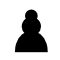
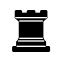
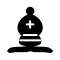
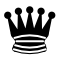
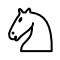
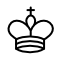
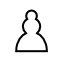
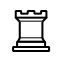
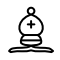
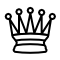
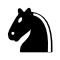
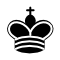

In [10]:
result = env.run(["main.py", "random"])
for agent in result[-1]:
    print("Status:", agent.status, "/ Reward:", agent.reward, "/ Time left:", agent.observation.remainingOverageTime)
env.render(mode="ipython", width=700, height=700)

Elapsed time: 0.00s, Remaining time: 10.00s
Valid engine move chosen: c2c3
Elapsed time: 0.19s, Remaining time: 9.81s
Valid engine move chosen: c3c4
Elapsed time: 0.39s, Remaining time: 9.61s
Valid engine move chosen: c4c5
Elapsed time: 0.57s, Remaining time: 9.43s
Valid engine move chosen: a2a3
Elapsed time: 0.76s, Remaining time: 9.24s
Valid engine move chosen: a3a4
Elapsed time: 0.96s, Remaining time: 9.04s
Valid engine move chosen: d2d3
Elapsed time: 1.18s, Remaining time: 8.82s
Using random move instead: c1h6
Elapsed time: 1.42s, Remaining time: 8.58s
Using random move instead: d3d4
Elapsed time: 1.66s, Remaining time: 8.34s
Using random move instead: e1e2
Elapsed time: 1.88s, Remaining time: 8.12s
Valid engine move chosen: d4d5
Elapsed time: 2.09s, Remaining time: 7.91s
Valid engine move chosen: e2d3
Elapsed time: 2.32s, Remaining time: 7.68s
Valid engine move chosen: a4a5
Elapsed time: 2.56s, Remaining time: 7.44s
Using random move instead: d1a4
Elapsed time: 2.80s, Remaining ti


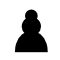
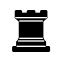
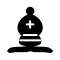
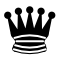
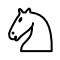
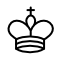
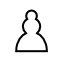
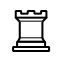
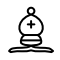
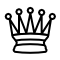
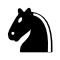
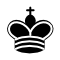

In [11]:
result = env.run(["main.py", "initial_agent.py"])
for agent in result[-1]:
    print("Status:", agent.status, "/ Reward:", agent.reward, "/ Time left:", agent.observation.remainingOverageTime)
env.render(mode="ipython", width=700, height=700)


Total games played: 50
Agent 1 Wins: 0
Agent 2 Wins: 0
Draws: 0
Agent 1 Errors: 0
Agent 2 Errors: 0
Agent 1 Average Reward: 0.13
Agent 2 Average Reward: 0.87



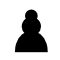
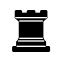
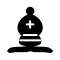
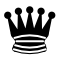
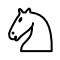
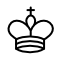
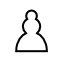
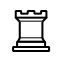
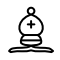
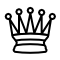
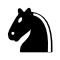
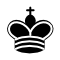

In [12]:
import sys

# Define the number of games to be played
num_games = 50

# Initialize variables to track results
wins = [0, 0]  # Wins for each agent
draws = 0
rewards = [0, 0]  # Total rewards for each agent
errors = [0, 0]  # Error counts for each agent

# Open a file to capture log messages
with open("bot_vs_initial_agent_logs.txt", "w") as log_file:
    # Redirect stdout to the log file
    original_stdout = sys.stdout
    sys.stdout = log_file

    # Play the games
    for game in range(num_games):
        result = env.run(["main.py", "initial_agent.py"])
        
        # Process results for the game
        for i, agent in enumerate(result[-1]):
            # Update win/draw counts
            if agent.status == "WINNER":
                wins[i] += 1
            elif agent.status == "DRAW":
                draws += 1
            elif agent.status == "ERROR":
                errors[i] += 1  # Count errors
            
            # Safely handle None reward
            rewards[i] += agent.reward if agent.reward is not None else 0
        
        # Log game results
        print(f"Game {game + 1}: Agent 1 Status: {result[-1][0].status}, Agent 2 Status: {result[-1][1].status}")

    # Restore stdout to the original terminal output
    sys.stdout = original_stdout

# Calculate average rewards
avg_rewards = [reward / num_games for reward in rewards]

# Display final statistics
print(f"\nTotal games played: {num_games}")
print(f"Agent 1 Wins: {wins[0]}")
print(f"Agent 2 Wins: {wins[1]}")
print(f"Draws: {draws}")
print(f"Agent 1 Errors: {errors[0]}")
print(f"Agent 2 Errors: {errors[1]}")
print(f"Agent 1 Average Reward: {avg_rewards[0]}")
print(f"Agent 2 Average Reward: {avg_rewards[1]}")

# Optionally, render the last game
env.render(mode="ipython", width=700, height=700)


Total games played: 50
Agent 1 Wins: 0
Agent 2 Wins: 0
Draws: 0
Agent 1 Errors: 0
Agent 2 Errors: 0
Agent 1 Average Reward: 0.85
Agent 2 Average Reward: 0.15



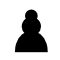
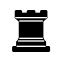
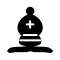
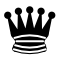
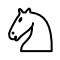
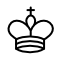
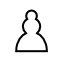
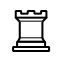
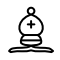
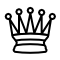
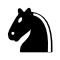
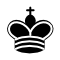

In [13]:
import sys

# Define the number of games to be played
num_games = 50

# Initialize variables to track results
wins = [0, 0]  # Wins for each agent
draws = 0
rewards = [0, 0]  # Total rewards for each agent
errors = [0, 0]  # Error counts for each agent

# Open a file to capture log messages
with open("initial_agent_vs_bot_logs.txt", "w") as log_file:
    # Redirect stdout to the log file
    original_stdout = sys.stdout
    sys.stdout = log_file

    # Play the games
    for game in range(num_games):
        result = env.run(["initial_agent.py", "main.py"])
        
        # Process results for the game
        for i, agent in enumerate(result[-1]):
            # Update win/draw counts
            if agent.status == "WINNER":
                wins[i] += 1
            elif agent.status == "DRAW":
                draws += 1
            elif agent.status == "ERROR":
                errors[i] += 1  # Count errors
            
            # Safely handle None reward
            rewards[i] += agent.reward if agent.reward is not None else 0
        
        # Log game results
        print(f"Game {game + 1}: Agent 1 Status: {result[-1][0].status}, Agent 2 Status: {result[-1][1].status}")

    # Restore stdout to the original terminal output
    sys.stdout = original_stdout

# Calculate average rewards
avg_rewards = [reward / num_games for reward in rewards]

# Display final statistics
print(f"\nTotal games played: {num_games}")
print(f"Agent 1 Wins: {wins[0]}")
print(f"Agent 2 Wins: {wins[1]}")
print(f"Draws: {draws}")
print(f"Agent 1 Errors: {errors[0]}")
print(f"Agent 2 Errors: {errors[1]}")
print(f"Agent 1 Average Reward: {avg_rewards[0]}")
print(f"Agent 2 Average Reward: {avg_rewards[1]}")

# Optionally, render the last game
env.render(mode="ipython", width=700, height=700)

In [14]:
!tar -czvf submission.tar.gz main.py libchess_agent.so

main.py
libchess_agent.so
